## Notebook Setup

In [1]:
# ipython setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import triangle
import pyamg
from matplotlib.tri import Triangulation, LinearTriInterpolator

# functions given to us in python files
from potential_flow import *
from panel_method_derivatives import panel_method_x_derivative

In the notebooks provided to us (parts 1-4) there are several functions and classes that are given and use but never edit ourselves. To save space in this notebook all such functions are copied into notebook_functions.py and specifically imported below. Wherever these functions are used within this report it is mentioned that they can be found in that python file and what they do is loosely explained.

In [3]:
# functions given to us in notebook 2
from notebook_functions import regular_polygon, area, length, grad_length, taylor_test, ShapeOptimisationProblem

# functions given to us in notebook 3
from notebook_functions import JacobiPreconditioner, SSORPreconditioner, AMGPreconditioner, SimpleCounter

# functions given to us in notebook 4
from notebook_functions import AirfoilFunctional, VerticalShapeOptimisation

In [4]:
# matplotlib preferences
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']
plt.rc('axes', titlesize=20, labelsize=15)
plt.rc('axes.formatter', limits=[-4, 4])
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('lines', linewidth=1, markersize=5)
plt.rc('figure', figsize=(5, 5))

<font size="1pt">Some $\LaTeX$ definitions hidden in this cell (double-click to reveal)</font>
$
\newcommand\vec[1]{\mathbf{#1}}
\newcommand\vphi{\boldsymbol{\phi}}
\newcommand\vsig{\boldsymbol{\sigma}}
\newcommand\vlam{\boldsymbol{\lambda}}
\newcommand\mat[1]{\underline{\mathbf{#1}}}
\newcommand\R{\mathbb{R}}
\newcommand\todo[1]{\textcolor{red}#1}
$

## 1) Solver Configuration for the Finite Element Potential Flow Model
Recommend the most efficient way to solve the first potential flow finite element model implemented in the PotentialFlowFE class from the potential_flow module. This is the exact same solver that was also used in part one. Give the reasons for your choice, and show the analysis you have done to make that decision. This should be based on question 1. to 4. in notebook one, and question 1 to 3. in notebook three.

First lets load in the airfoil and setup the matrix equation that is to be solved (as these steps are the same for all methods of solving the equation). To create the meshes and discretize the problem into a matrix equation we will use the provided PotentialFlowFE class found in the "potential_flow.py" python file. Options that we have to choose are the mesh boarders, flow velocity and angle of attack, all of which are chosen arbitrarily to be realistic.

We will load the matrices as sparse since this has already been shown to be greatly faster for both the Scipy Direct and Conjugate Gradient methods (spl.spsolve and spl.cg) in notebook 3. Later we will see the need for different resolution meshes, so we will create a list of matrices with different resolution meshes. I have chosen resolutions up to $\approx5\times10^{-5}$ as smaller than this becomes excessively long to load and would likely be even longer to solve.

In [6]:
# polygon describing the outer boundary
outer_boundary = [[-2, -2], [3, -2], [3, 2], [-2, 2], [-2, -2]]

# polygon describing a NACA0012 airfoil (renamed airfoil)
airfoil = np.loadtxt('data/airfoil.dat')

# options
resolutions = 0.01 / (2 ** np.arange(0, 8)) # from 1e-2 to 8e-5
u_inf = 1.0            # flow velocity at infinite distance
alpha = np.deg2rad(4)  # angle of attack

In [4]:
# create the PotentialFlowFE instances
pfs = [PotentialFlowFE(airfoil, outer_boundary, res, u_inf, alpha) for res in resolutions]

# create the matrix equations
As, bs = [], []
for pf in pfs:
    A, b = pf.assemble(sparse=True)
    print(A.shape)
    As.append(A)
    bs.append(b)

[Text(0.5,1,'0.005 Resolution Mesh')]

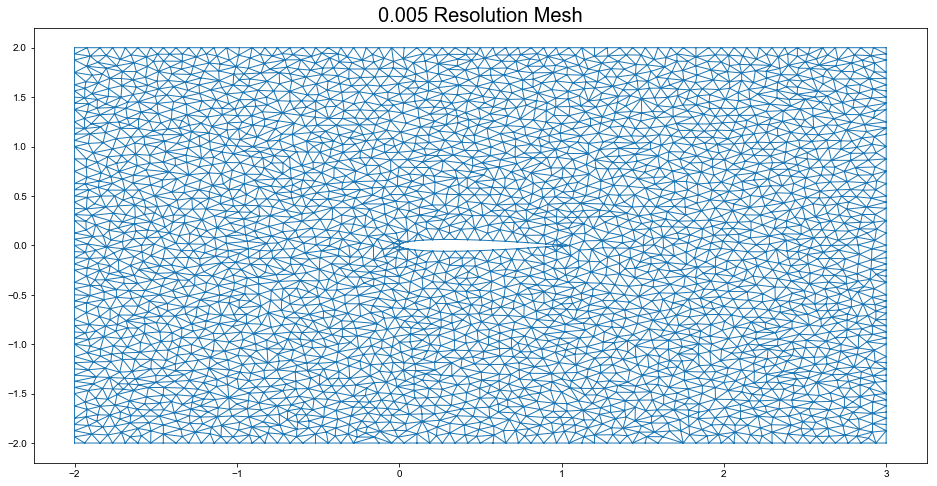

In [6]:
# plot a single mesh to ensure correct loading
fig, ax = plt.subplots(figsize=(16,8))
pfs[1].plot_mesh(ax)
ax.set(title= str(resolutions[1]) + " Resolution Mesh")

Now the matrix equations are loaded we have multiple methods that could be used to solve this matrix equation. However if we can prove that the matrix $A$ is symmetric positive definite (SPD) then we know that the Conjugate Gradient method is very efficient ("For linear systems based on an SPD matrix, the preconditioned Conjugate Gradient method is usually the method of choice" - Lecture 7).

Looking over the derivation for the matrix $\mat A$ we can show that the matrix is positive definite algebraically. From the derivations in Workbook One we have:
$$
  \int_\Omega \left(\nabla q\right) \cdot\left(\nabla \phi\right) ~dx = \vec q^T\mat A\vphi
$$

where in this case $\phi$ is what we are solving for, in this case $v$ and $q$ is a test function which we are free to choose. If we choose $q$ to be $v$ then we have:
$$
  \vec v^T\mat Av = \int_\Omega \left(\nabla v\right)^2 ~dx > 0
$$

where the last inequality is known as $\left(\nabla v\right)^2$ must be positive or zero (which we can ignore as the trivial case if a uniform velocity field, else in the general case this is semi-positive definite). Hence the matrix is positive definite as any velocity $v$ is possible in reality, which satisfies the condition for any vector $v$. The symmetric property can be seen in the following equation from the same workbook:

$$
 \mat A_{ij} = \int_\Omega \left(\nabla \psi_i\right) \cdot\left(\nabla \psi_j\right)~dx \;\
$$

here the right hand equation is unchanged upon swapping i and j, hence the matrix $\mat A_{ij} = \mat A_{ji}$, so must be symmetric. From these we know that the matrix is SPD therefore the Conjugate Gradient method is the one we should use.

We have also been suggested a number of different stopping criterion to reduce the number of iterations needed, however using scipy's solvers means we can't change the stopping criteria, only specify the tolerance of it, for which the default (1e-5) seems appropriate.

For Conjugate Gradient method we do have multiple different pre-conditioners which can improve the rate of convergence by changing the problem to an equivalent one with a better condition number. The pre-conditioners must be SPD to work with conjugate gradient, such pre-conditioners include:

- Jacobi 
- SSOR
- AMG

Within the "notebook_functions.py" file there are classes three classes that hold implementations (or wrappers pyamg functions) of these pre-conditioners.

We will find which of these pre-conditioners give the best efficiency for this potential flow problem without solving each for every resolution (which will take a long time) by to trying them all on a single mesh (0.05 is chosen so for reasonable runtime and resolution). They will be analysed on number of iterations (using the counter class also found in "notebook_functions.py"), runtime (using %timeit) and how these scale with mesh resolution.

In [11]:
# choose the correct resolution
A,b = As[1], bs[1]

# setup the pre-conditioners
jacobi = JacobiPreconditioner(A)
ssor = SSORPreconditioner(A, omega=1.5)
amg = AMGPreconditioner(A)
Ms = [None, jacobi, ssor, amg]

# lists for saving results
names = ["none", "jacobi", "ssor", "amg"]
times, stds, iterations = [], [], []

# solve for each preconditioner
for M in Ms:
    # create a counter
    counter = SimpleCounter()
    
    # solve with counter and timeit
    phi = spl.cg(A, b, tol=1e-5, M=M, callback=counter)
    t = %timeit -o spl.cg(A, b, tol=1e-5, M=M)
    
    # save the results
    times.append(t.average)
    stds.append(t.stdev)
    iterations.append(counter.count)

55.7 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.4 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
89.4 ms ± 5.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.9 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


To check that these are actually solving the system as we expect we will plot one of the solutions to see what it looks like.

[-0.5, 1.5, -0.5, 0.5]

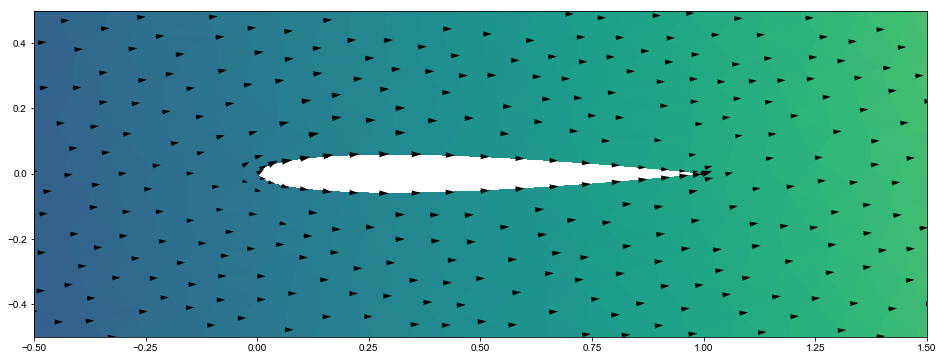

In [17]:
# plot the final methods solution
plt.figure(figsize=(16,6))
pfs[1].plot_solution(phi[0])
plt.axis([-0.5, 1.5, -0.5, 0.5])

All looks good, now lets compare the runtimes and iterations of each pre-conditioner.

[Text(0,0.5,'Iterations [s]'), Text(0.5,1,'CG Low Res Iterations')]

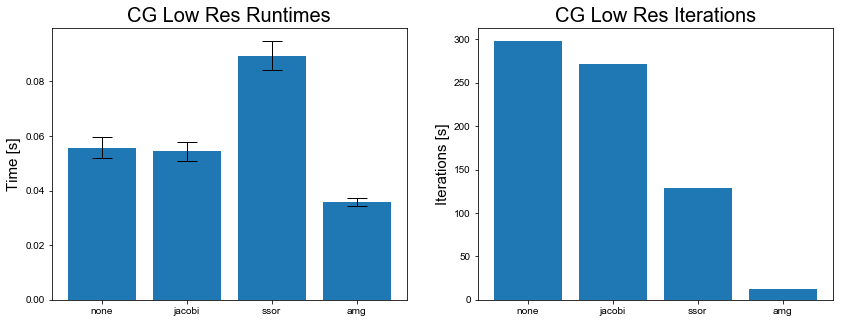

In [13]:
# plot the times and iterations
fig, axs = plt.subplots(1, 2, figsize = [14, 5])
axs[0].bar(names, times, yerr = stds, capsize=10)
axs[0].set(ylabel="Time [s]", title="CG Low Res Runtimes")
axs[1].bar(names, iterations)
axs[1].set(ylabel="Iterations [s]", title="CG Low Res Iterations")

At this resolution AMG is seen to be faster with SSOR being slower than no pre-conditioner at all and Jacobi being marginally better. Re-running this with different resolutions vary the degree of performance increase by AMG but it is always either the best or (for very low resolutions) about as good as the other methods. 

The iterations of AMG are significantly lower than the other methods, suggesting it would scale better for matrices with a high cost to evaluate (i.e. larger problems or higher dimensions), though the number of evaluations at each iteration would need to be considered as well. 

We should also consider the initialisation time for each pre-conditioner as this might be significant to the overall runtime.

In [18]:
print("Low res initalisation")
%timeit jacobi = JacobiPreconditioner(As[1])
%timeit ssor = SSORPreconditioner(As[1], omega=1.5)
%timeit amg = AMGPreconditioner(As[1])

print("\nHigh res initalisation")
%timeit jacobi = JacobiPreconditioner(As[-1])
%timeit ssor = SSORPreconditioner(As[-1], omega=1.5)
%timeit amg = AMGPreconditioner(As[-1])

Low res initalisation
150 µs ± 8.24 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
26 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
18.1 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

High res initalisation
9.52 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
106 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
844 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


AMG is seen to be much longer than the others, with a setup time comparable to the solve time at these resolutions. However even with this time included it is about as good as Jacobi and no pre-conditioner, so it is this is the one I will consider best here. To evaluate this solvers performance we will use all the different grid resolutions to compare with Scipy's general direct solver (for a sparse matrix). Only time is considered now as iterations is meaningless for a direct solver.

In [20]:
# setup
names = ["CG AMG", "spsolve"]
times = np.zeros((len(names), len(As)))
stds = np.zeros_like(times)

# loop over all resolutions
for i in range(len(As)):
    
    # iterative method
    M = AMGPreconditioner(As[i])
    t = %timeit -o spl.cg(As[i], bs[i], tol=1e-5, M=M)
    times[0, i] = t.average
    stds[0, i] = t.stdev

    # direct method
    t = %timeit -o spl.spsolve(As[i], bs[i])
    times[1, i] = t.average
    stds[1, i] = t.stdev

29.1 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.4 ms ± 568 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.8 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
87.8 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.2 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
179 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
183 ms ± 5.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
338 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
500 ms ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
988 ms ± 80.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.18 s ± 69.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.04 s ± 71.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.73 s ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.56 s ± 228 ms per loop (

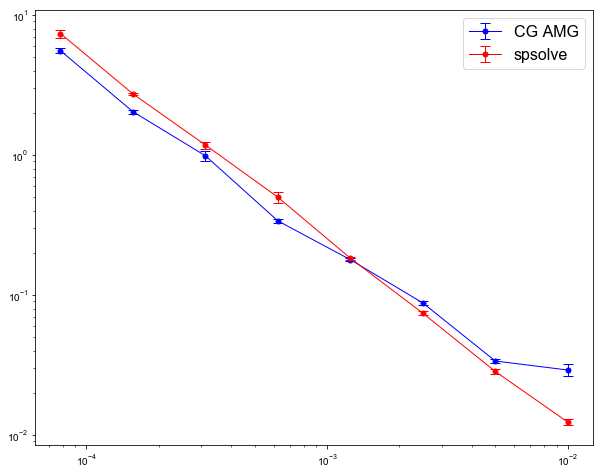

In [21]:
# plot these results
plt.figure(figsize = [10,8])
plt.errorbar(y=times[0,:], x=resolutions, yerr=stds[0,:], fmt='b-o', capsize=5, label=names[0])
plt.errorbar(y=times[1,:], x=resolutions, yerr=stds[1,:], fmt='r-o', capsize=5, label=names[1])
plt.gca().set(xscale='log', yscale='log')
plt.legend()

We can see that after a certain resolution around $5\times10^{-2}$ the CG AMG method overtakes the direct solver. However the difference is not huge, for the highest resolution the improvement is $\tilde 1s$ (once the setup time is accounted for), which is $\tilde13\%$ improvement over the direct solver. After around $5\times10^{-3}$ the lines appear roughly parallel, suggesting that not much further improvement of the AMG method will be obtained from finer resolutions, however this would need to be actually tested to be sure.

For this problem at these resolutions I would therefore recommend the CG AMG method due to its improvements on problems with significant runtimes (i.e. over $1$ second). However if convenience of use is a large factor Scipy's spsovle direct method could be used with very little performance loss. Although the percentage of improvement of CG AMG may not improve relative to spsolve for larger problems, the actual time saved will be more significant ($13\%$ of an hour is more worth it), hence CG AMG would be preferred were this problem say expanded into three dimensions.

## 2)  Solver Configuration for the "Kutta" Finite Element Potential Flow Model
Recommend the most efficient way to solve the second potential flow finite element model, which
include circulation and the Kutta condition, implemented in the KuttaPotentialFlowFE class
from the potential_flow module. Again, give the reasons for your choice, and show the analysis
you have done to make that decision. This should be based on question 4. in notebook three.

This is very similar to question 1 in that we have a matrix equation with which to find an appropriate solver. However now the problem is far more complex as we are accounting for lift with a Point Vortex in our field which must have a center obeyed by the Kutta condition. The inner intricacies of this have been spared from us and we have been instructed to look at the following Krylov methods with one of the following pre-conditioners:

- CG
- GMRES
- BiCGStab 
- ssor pre-conditioner 
- algebraic multigrid pre-conditioner

Again we should first create the matrix equations we wish to solve. We can use the same constants and resolutions as the previous parts, but now we use the KuttaPotentialFlowFE class to formulate our matrix equations (in the same manner as with PotentialFlowFE).

In [40]:
# the new resolutions
resolutions = 0.01 / (2 ** np.arange(0, 8)) # from 1e-2 to 1e-4

# create the KuttaPotentialFlowFE instances
pfs = [KuttaPotentialFlowFE(airfoil, outer_boundary, res, u_inf, alpha) for res in resolutions]

# create the matrix equations
As, bs = [], []
for pf in pfs:
    A, b = pf.assemble()
    print(A.shape)
    As.append(A)
    bs.append(b)

(1653, 1653)
(3240, 3240)
(6365, 6365)
(12666, 12666)
(25100, 25100)
(49804, 49804)
(99747, 99747)
(198944, 198944)


Knowing a bit about the methods we are using CG requires a symmetric positive definite (SPD) matrix, where as GMRES and BiCGStab are both valid for non-SPD matrices. Let's check that after the addition of the Kutta condition the properties of the new matrices we are solving with the lowest resolution matrix.

In [13]:
# make it dense so it is easier to analyse
A = As[0].todense()

# find eigenvalues
eigen_vals = sl.eig(A)[0]

# check properties
print("is A (without fixing) symetric (to abitary precision):\t", np.isclose(A, A.T).all())
print("is A (without fixing) constant a PD matrix:\t\t", all(eigen_vals > 0))

is A (without fixing) symetric (to abitary precision):	 False
is A (without fixing) constant a PD matrix:		 True


We can see the system is no longer symmetric. This makes sense in terms of the derivation for the Kutta condition, $\Gamma$ is said to "influence the finite element equation associated with all the boundary vertices" and we had no restriction on our airfoil shape, hence the last column and row of the matrix $\mat A$ are not guaranteed to be asymmetric. Because of this we can exclude CG method from our analysis as it requires symmetry for guaranteed convergence.

We will include both methods without pre-conditioners, just in case the ones chosen are detrimental to this particular system. So now we have 6 methods, 8 mesh resolutions and timing needs several repeats ($~300$ simulations) to test each would take quite a long time, especially if some of the solvers are particularly slow. Lets analyse a single resolution first to see if any are significantly slower so can be excluded (like we did before).

In [38]:
# setup
names = ["GMRES", "GMRES SSOR", "GMRES AMG", "BiCGStab", "BiCGStab SSOR", "BiCGStab AMG"]
times = np.zeros(len(names))
stds = np.zeros_like(times)
iterations = np.zeros_like(times)
counter = SimpleCounter()

# create the pre-conditioner matrices
ssor = SSORPreconditioner(As[0])
amg = AMGPreconditioner(As[0])
Ms = [None, ssor, amg]
funcs = [spl.gmres, spl.bicgstab]

# counter for method number so we save results in the right place
method = 0

for f in funcs:
    for M in Ms:
        # find the number of iterations it takes
        counter.count = 0
        phi = f(As[0], bs[0], tol=1e-5, M=M, callback=counter)
        iterations[method] = counter.count

        # find the time it takes
        t = %timeit -o f(As[0], bs[0], tol=1e-5, M=M)
        times[method] = t.average
        stds[method] = t.stdev

        # increase the method counter
        method += 1

358 ms ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
214 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.7 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.5 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.5 ms ± 587 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.8 ms ± 730 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


[Text(0,0.5,'Iterations [s]'), Text(0.5,1,'Kutta Low Res Iterations')]

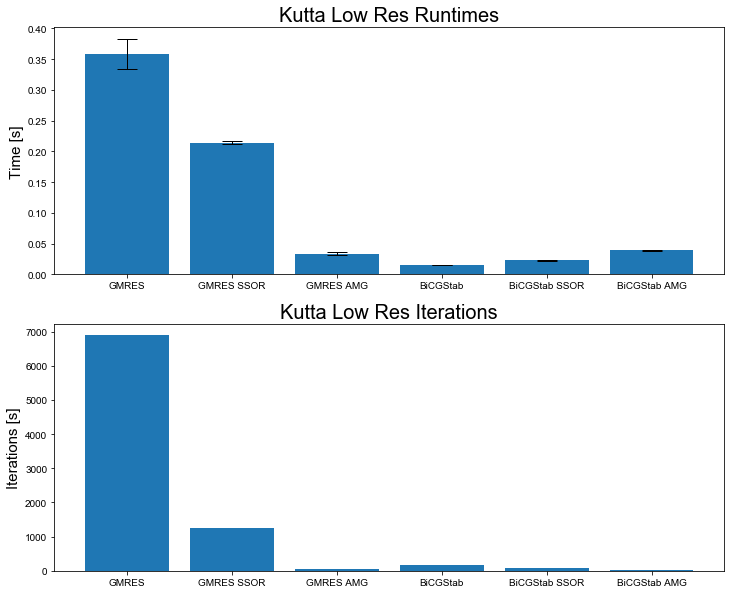

In [39]:
# plot the times and iterations
fig, axs = plt.subplots(2, 1, figsize = [12, 10])
axs[0].bar(names, times, yerr = stds, capsize=10)
axs[0].set(ylabel="Time [s]", title="Kutta Low Res Runtimes")
axs[1].bar(names, iterations)
axs[1].set(ylabel="Iterations [s]", title="Kutta Low Res Iterations")

So here we see that GMRES and GMRES SSOR are significantly longer in both runtime and iterations. Though it is not certain that these will be so bad for all resolutions it is reasonable exclude these methods from further analysis. Now we only have four methods to test, and we know each of them are relatively fast so should be ok to compare these methods with each mesh resolution to see how they scale.

Like before we should also consider the setup time for each pre-conditioner, however these are unchanged from the previous question as the matrix sizes are all the same as before, so we know that only AMG is significant so should be considered as slightly slower than the values we time for it.

In [41]:
# setup
names = ["GMRES AMG", "BiCGStab", "BiCGStab SSOR", "BiCGStab AMG"]
times = np.zeros((len(names), len(As)))
stds = np.zeros_like(times)
iterations = np.zeros_like(times)
counter = SimpleCounter()
funcs = [spl.gmres, spl.bicgstab]

# loop over all resolutions
for i in range(len(As)):
    
    # find pre-conditioner matrices
    ssor = SSORPreconditioner(As[i])
    amg = AMGPreconditioner(As[i])
    Ms = [None, ssor, amg]
    
    # counter for method number so we save results in the right place
    method = 0
    
    for f in funcs:
        for M in Ms:
            if not ((f == spl.gmres) and (M != amg)):
                # find the number of iterations it takes
                counter.count = 0
                phi = f(As[i], bs[i], tol=1e-5, M=M, callback=counter)
                iterations[method, i] = counter.count

                # find the time it takes
                t = %timeit -o f(As[i], bs[i], tol=1e-5, M=M)
                times[method, i] = t.average
                stds[method, i] = t.stdev

                # increase the method counter
                method += 1


33.8 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.3 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
23 ms ± 689 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.7 ms ± 602 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
55.9 ms ± 781 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.6 ms ± 817 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.8 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.3 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
182 ms ± 4.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
110 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
163 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
204 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
952 ms ± 46.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
255 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
367 ms ± 17.8 ms per l

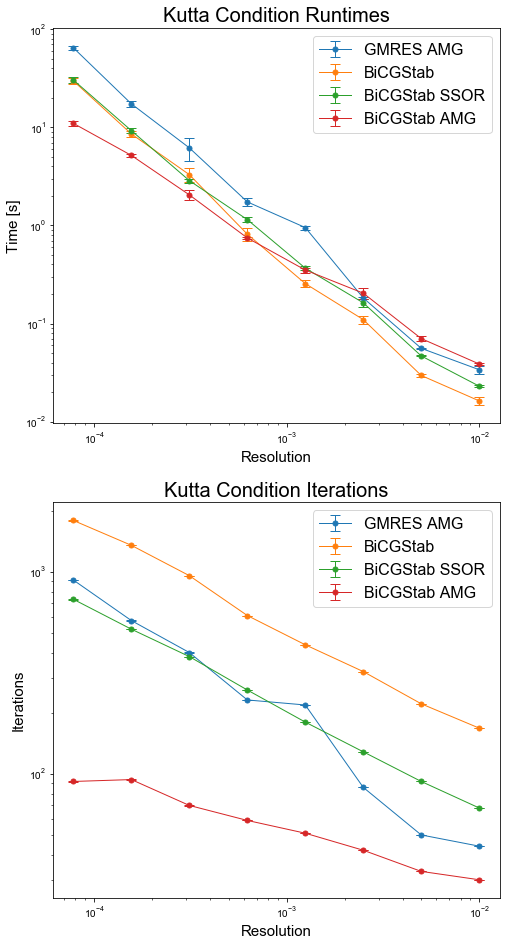

In [42]:
# plot the results
fig, axs = plt.subplots(2, 1, figsize=[8, 16])
for i in range(len(names)):
    axs[0].errorbar(y=times[i,:], x=resolutions, yerr=stds[i,:], fmt='-o', capsize=5, label=names[i])
    axs[1].errorbar(y=iterations[i,:], x=resolutions, yerr=stds[i,:], fmt='-o', capsize=5, label=names[i])

# configure the axes
[ax.set(xscale='log', yscale='log', xlabel='Resolution') for ax in axs]
axs[0].set(ylabel='Time [s]', title='Kutta Condition Runtimes')
axs[1].set(ylabel='Iterations', title='Kutta Condition Iterations')
[ax.legend() for ax in axs]

We see that all the solvers are roughly similar in their runtiems. For lower resolutions BiCGStab without a pre-conditioner is fastest and at higher resolutions this is overtaken by GMRES AMG. However AMG must be taken with consideration of its initialisation time, previously founf to be a bit less than one second for the largest matrix. Compared to the runtime this is significant, but AMG is still fastest at the highest resolution despite this, combined with having consistently the lowest iteration count it is the method I would recommend here.

## 3) Solver Configuration for the Panel Method
Recommend the most efficient way to solve the panel method potential flow model implemented in the PotentialFlowPanelMethod class. State the reasons for your choice, and show the analysis
you have done to make that decision. This should be based on question 5. in notebook three. For this
case you may ignore the use of pre-conditioners.

Unlike for the previous two methods we now choose our resolution by the number of piecewise linear functions in our airfoil (i.e. the number of edges). Hence to compare different methods we need to load multiple airfoils with different resolutions.

In [160]:
# load the airfoils
airfoils = [np.loadtxt('data/airfoil' + s + '.dat') for s in ["", "_200", "_1000"]]

# create the object instances
pfpms = [PotentialFlowPanelMethod(af, u_inf, alpha) for af in airfoils]

# create the matrices to be solved
As, bs = [], []
for pf in pfpms:
    A, b = pf.assemble()
    print(A.shape)
    As.append(A)
    bs.append(b)

(41, 41)
(201, 201)
(1001, 1001)


Next we should inspect the matrices formulated from the panel method, to see what sort of system we are dealing with and hence what solvers are valid.

In [29]:
# check type of A
print("Matrix A is stored in type: ", type(As[0]))

# check the sparcity of A
print("The number of zero entries: ", (As[0]==0).sum())

# find eigenvalues
eigen_vals = sl.eig(As[0])[0]

# check properties
print("is A (without fixing) symetric (to abitary precision):\t", np.isclose(As[0], As[0].T).all())
print("is A (without fixing) constant a PD matrix:\t\t", all(eigen_vals > 0))

Matrix A is stored in type:  <class 'numpy.ndarray'>
The number of zero entries:  0
is A (without fixing) symetric (to abitary precision):	 False
is A (without fixing) constant a PD matrix:		 True


So first we see that unlike any of the previous finite element systems we have solving previously this matrix is dense, fully dense in fact, so we have to use methods viable for dense matrices. Fortunately those in the scipy.sparse.linalg are designed to accept both sparse and dense matrices, so we don't need to find alternatives. As the system is not symmetric the Conjugate Gradient (CG) method is not viable here and we have been instructed to ignore pre-conditioners. Hence from the previously introduced methods we have the following options:

- direct (sl.solve)
- BiCgStab
- GMRES

Before we start comparing these lets do a sanity check with each of the methods to ensure that they can solve this problem, agree with each other on the lift coefficient value and the value given is a sensible one.

0.47772616515867544
0.47773877676033205
0.4777254450474766


(-1.0, 1.999999999999998, -0.30000000000000004, 0.3)

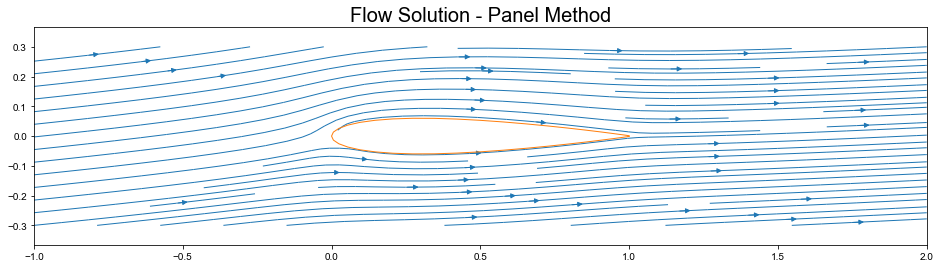

In [30]:
# compare lift coefficents for each method
sigma_direct = sl.solve(As[0], bs[0])
print(pfpms[0].lift_coeffcient(sigma_direct))

sigma_bicgstab = spl.bicgstab(As[0], bs[0], tol=1e-5)[0]
print(pfpms[0].lift_coeffcient(sigma_bicgstab))

sigma_gmres = spl.gmres(As[0], bs[0], tol=1e-5)[0]
print(pfpms[0].lift_coeffcient(sigma_gmres))

# plot the last one to see it looks reasonable
plt.figure(figsize=(16,4))
x, y = np.meshgrid(np.linspace(-1, 2, 40), np.linspace(-.3,.3, 40))
pfpms[0].plot_solution(sigma_gmres, x, y)
plt.title('Flow Solution - Panel Method')
plt.axis('equal')

These all agree on there lift values to 4dp and the stream lines over the airfoil for the final simulation seem reasonable, so we can be pretty sure this is working correctly. Now we will compare there runtimes. Note we will also run each solver without any pre-conditioner just in case they are detrimental to this particular problem.

In [31]:
# setup
names = [ "direct", "BiCGStab", "GMRES"]
times = np.zeros((len(names), len(pfpms)))
stds = np.zeros_like(times)

# for each airfoil
for i in range(len(airfoils)):

    # solve direct
    t = %timeit -o sl.solve(As[i], bs[i])
    times[0, i] = t.average
    stds[0, i] = t.stdev
    
    # solve BiCGSTAB
    t = %timeit -o spl.bicgstab(As[i], bs[i], tol=1e-5)
    times[1, i] = t.average
    stds[1, i] = t.stdev
    
    # solve GMRES
    t = %timeit -o spl.gmres(As[i], bs[i], tol=1e-5)
    times[2, i] = t.average
    stds[2, i] = t.stdev
    

316 µs ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.61 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.29 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.8 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.57 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.1 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
72.3 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.1 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.8 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


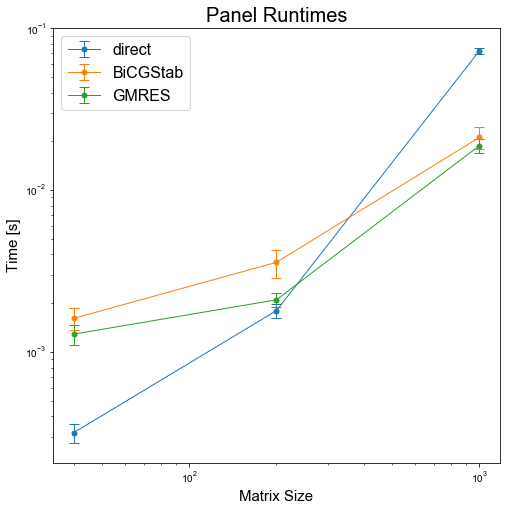

In [32]:
# plot the results
sizes = [40, 200, 1000]
fig, ax = plt.subplots(figsize=[8, 8])
for i in range(len(names)):
    ax.errorbar(y=times[i,:], x=sizes, yerr=stds[i,:], fmt='-o', capsize=5, label=names[i])
    
ax.set(xscale='log', yscale='log', xlabel='Matrix Size', ylabel='Time [s]', title='Panel Runtimes')
ax.legend()

Though for the lower resolutions the direct method is quicker it seems as though the two iterative methods are better for the larger problems. As only 3 airfoil resolutions are available these results are inconclusive, however extrapolation of these gives us a guess as to how they would behave for larger problems.

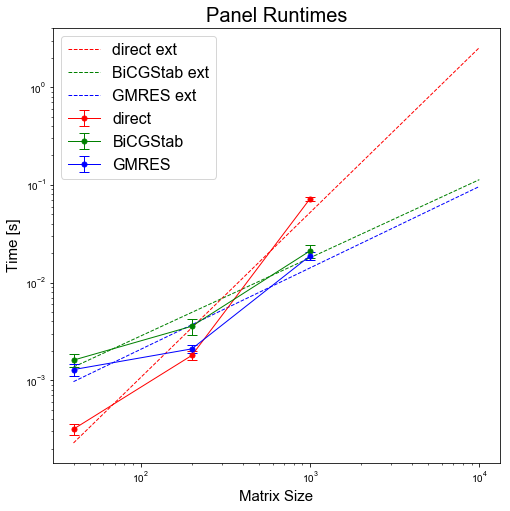

In [33]:
# fit a line in logspace
params = [np.polyfit(np.log10(sizes), t, 1) for t in np.log10(times)]

# plot the results again with an extrapolation
x = np.linspace(sizes[0], sizes[-1]*10, 100)
cols = ['r', 'g', 'b']
fig, ax = plt.subplots(figsize=[8, 8])
for i in range(len(names)):
    ax.errorbar(y=times[i,:], x=sizes, yerr=stds[i,:], fmt=cols[i]+'-o', capsize=5, label=names[i])
    ax.plot(x, 10**params[i][1] * x**params[i][0], cols[i]+'--', label=names[i] + ' ext')
    
ax.set(xscale='log', yscale='log', xlabel='Matrix Size', ylabel='Time [s]', title='Panel Runtimes')
ax.legend()

Since only resolutions where the direct solver is faster are for relatively quick simulations (under 0.01 sec) I would recommend the either the BiCGStab ot GMRES models. Here it appears that GMRES is the better of the two but this is a marginal improvement which may not be true for resolutions over $10^4$ in matrix size as the two lines appear to be nearing each other. Based on the evidence we have however GMRES is the better solver for this problem.

## 4) Validation of the Potential Flow models
Provide some validation for the lift coefficients predicted by the KuttaPotentialFlowFE and PotentialFlowPanelMethod models based on question 6. in notebook three.

We need to ensure our simulations are realistic, which is best done by comparing to previously vairfied results. Such results have been provided for various angles of attack. Lets load in this data to see what it looks like.

In [156]:
data = pd.read_csv("data/xf-n0012-il-1000000-n5.csv", skiprows=10)
data.head(10)

,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr
0,-19.25,-1.2322,0.11416,0.11116,0.0052,1.0,0.0103
1,-19.00,-1.2711,0.10336,0.10020,-0.0004,1.0,0.0103
2,-18.75,-1.3084,0.09309,0.08977,-0.0057,1.0,0.0103
3,-18.50,-1.3433,0.08350,0.08002,-0.0106,1.0,0.0102
4,-18.25,-1.3730,0.07497,0.07133,-0.0150,1.0,0.0102
5,-18.00,-1.3978,0.06745,0.06366,-0.0188,1.0,0.0102
6,-17.75,-1.4170,0.06096,0.05702,-0.0221,1.0,0.0103
7,-17.50,-1.4317,0.05530,0.05123,-0.0249,1.0,0.0103
8,-17.25,-1.4420,0.05042,0.04621,-0.0272,1.0,0.0104
9,-17.00,-1.4487,0.04625,0.04192,-0.0289,1.0,0.0105


In [157]:
data.describe()

,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.008224,0.001194,0.023265,0.017854,-0.000032,0.512612,0.514192
std,11.314968,1.051368,0.023201,0.023937,0.014607,0.442751,0.442807
min,-19.250000,-1.453600,0.006620,0.001100,-0.031700,0.010200,0.010200
25%,-9.812500,-1.067175,0.008755,0.002915,-0.005325,0.020950,0.020950
50%,0.125000,0.013700,0.014460,0.008395,0.000000,0.519350,0.543400
75%,9.812500,1.067175,0.025348,0.020112,0.005225,1.000000,1.000000
max,19.250000,1.455100,0.114160,0.111160,0.031500,1.000000,1.000000


We see there are 152 data points from $-19.25$ to $19.25$ degrees with intervals of $0.25$ degrees, which actually means that some of these points are missing. To prevent solving more than is needed we will only consider every 4th angle. Both KuttaPotentialFlowFE and PotentialFlowPanelMethod models are to be used with the previously found best methods for solving them. At first we will use a relatively low resolution, a see the impact this has a bit later.

In [158]:
# find the angles we want to solve for
data_trunc = data[::4]
deg_angs = data_trunc["Alpha"].tolist()

# setup
angles = np.deg2rad(deg_angs)
names = ["Panel", "Kutta"]
coefficents = np.zeros((len(names), len(angles)))

In [152]:
# for each angle
for i, ang in enumerate(angles):
    print('solving ang =', ang, " (%i)" % i)
    
    # solve with Panel Method
    pfpm = PotentialFlowPanelMethod(airfoils[0], u_inf, ang)
    A, b = pfpm.assemble()
    sigma = spl.gmres(A, b, tol=1e-5)[0]
    coefficents[0, i] = pfpm.lift_coeffcient(sigma)
    
    # solve with the Kutta method
    kpfs = KuttaPotentialFlowFE(airfoils[0], outer_boundary, 0.01, u_inf, ang)
    A, b = kpfs.assemble()
    phi = spl.bicgstab(A, b, tol=1e-5)[0]
    coefficents[1, i] = kpfs.lift_coeffcient(phi)

solving ang = -0.33597588100890846  (0)
solving ang = -0.31852258848896514  (1)
solving ang = -0.3010692959690218  (2)
solving ang = -0.28361600344907856  (3)
solving ang = -0.26616271092913524  (4)
solving ang = -0.24870941840919197  (5)
solving ang = -0.23125612588924865  (6)
solving ang = -0.21380283336930536  (7)
solving ang = -0.19634954084936207  (8)
solving ang = -0.17889624832941878  (9)
solving ang = -0.16144295580947549  (10)
solving ang = -0.1439896632895322  (11)
solving ang = -0.1265363707695889  (12)
solving ang = -0.1090830782496456  (13)
solving ang = -0.08726646259971647  (14)
solving ang = -0.06981317007977318  (15)
solving ang = -0.05235987755982989  (16)
solving ang = -0.03490658503988659  (17)
solving ang = -0.013089969389957472  (18)
solving ang = 0.004363323129985824  (19)
solving ang = 0.02181661564992912  (20)
solving ang = 0.039269908169872414  (21)
solving ang = 0.05672320068981571  (22)
solving ang = 0.07417649320975901  (23)
solving ang = 0.0916297857297023

[Text(0,0.5,'Fractional Difference'),
 Text(0.5,0,'angle [deg]'),
 Text(0.5,1,'Difference to Reference')]

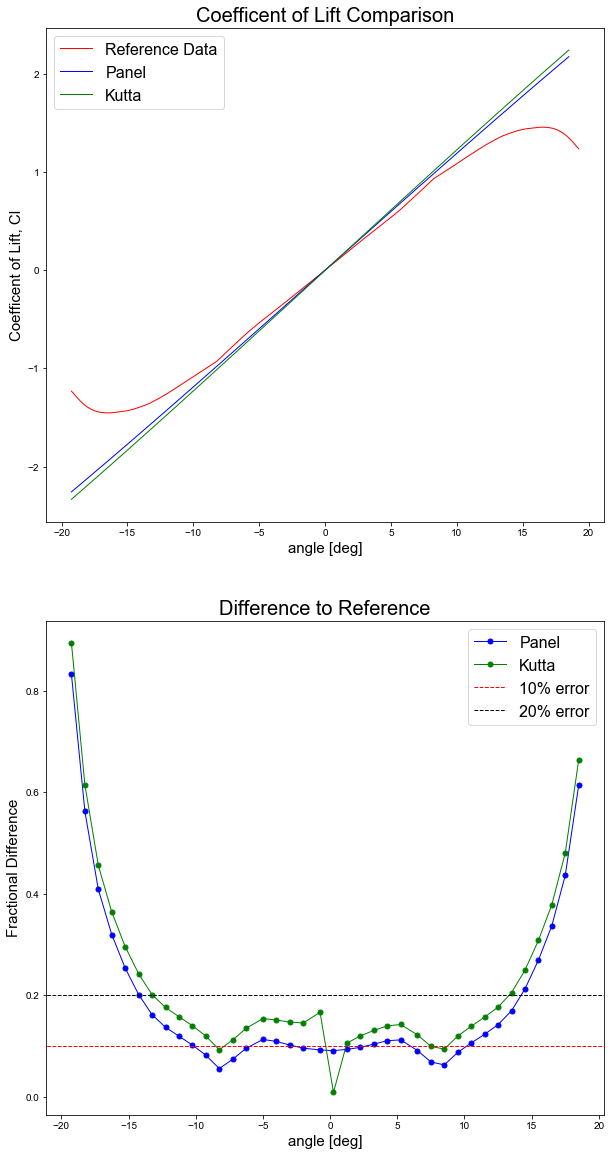

In [168]:
# setup
fig, axs = plt.subplots(2, 1, figsize=[10, 20])

# plot both values
axs[0].plot(data['Alpha'], data["Cl"], 'r-', label='Reference Data')
axs[0].plot(deg_angs, coefficents[0, :], 'b-', label=names[0])
axs[0].plot(deg_angs, coefficents[1, :], 'g-', label=names[1])
axs[0].legend()
axs[0].set(title="Coefficent of Lift Comparison", xlabel="angle [deg]", ylabel="Coefficent of Lift, Cl")

# plot the difference
diff = lambda x:abs((x - data_trunc['Cl'])/data_trunc['Cl'])
axs[1].plot(deg_angs, diff(coefficents[0, :]), 'b-o', label=names[0])
axs[1].plot(deg_angs, diff(coefficents[1, :]), 'g-o', label=names[1])
axs[1].axhline(0.1, -20, 20, linestyle='--', c='r', label="10% error")
axs[1].axhline(0.2, -20, 20, linestyle='--', c='k', label="20% error")
axs[1].legend()
axs[1].set(title="Difference to Reference", xlabel="angle [deg]", ylabel="Fractional Difference")

Firstly we see that there is a reasonable agreement between the two models and the reference data, with the best agreement being zero at zero degrees. This value makes perfect sense as the airfoil we are testing is symmetric through the line $x=0$, hence for zero angle of attack there is no asymmetry to the problem so there should be no net lift.

Looking at the error plot we see more clearly that the panel method is better at approximating the reference data, at least for this resolution. The overtaking by Kutta at $\sim 0^o$ is likely to chance from the fact we only considered every 4th point to save computation time. There is agreement within $\pm20\%$ for up to around $\pm13^o$ for both methods however only panel is consistently around $\pm10\%$ or better( doing so for around $\pm10^o$).

Now lets see what the affect of increasing resolution has for both methods. Note that since the methods use different types of resolution (one is mesh resolution while the other is number of panels) it is hard to increase the resolutions equally, so the relative improvements may not be comparable between the two. 

In [169]:
# for each angle
for i, ang in enumerate(angles):
    print('solving ang =', ang, " (%i)" % i)
    
    # solve with Panel Method
    pfpm = PotentialFlowPanelMethod(airfoils[1], u_inf, ang)
    A, b = pfpm.assemble()
    sigma = spl.gmres(A, b, tol=1e-5)[0]
    coefficents[0, i] = pfpm.lift_coeffcient(sigma)
    
    # solve with the Kutta method
    kpfs = KuttaPotentialFlowFE(airfoils[0], outer_boundary, 0.001, u_inf, ang)
    A, b = kpfs.assemble()
    phi = spl.bicgstab(A, b, tol=1e-5)[0]
    coefficents[1, i] = kpfs.lift_coeffcient(phi)


solving ang = -0.33597588100890846  (0)
solving ang = -0.31852258848896514  (1)
solving ang = -0.3010692959690218  (2)
solving ang = -0.28361600344907856  (3)
solving ang = -0.26616271092913524  (4)
solving ang = -0.24870941840919197  (5)
solving ang = -0.23125612588924865  (6)
solving ang = -0.21380283336930536  (7)
solving ang = -0.19634954084936207  (8)
solving ang = -0.17889624832941878  (9)
solving ang = -0.16144295580947549  (10)
solving ang = -0.1439896632895322  (11)
solving ang = -0.1265363707695889  (12)
solving ang = -0.1090830782496456  (13)
solving ang = -0.08726646259971647  (14)
solving ang = -0.06981317007977318  (15)
solving ang = -0.05235987755982989  (16)
solving ang = -0.03490658503988659  (17)
solving ang = -0.013089969389957472  (18)
solving ang = 0.004363323129985824  (19)
solving ang = 0.02181661564992912  (20)
solving ang = 0.039269908169872414  (21)
solving ang = 0.05672320068981571  (22)
solving ang = 0.07417649320975901  (23)
solving ang = 0.0916297857297023

[Text(0,0.5,'Fractional Difference'),
 Text(0.5,0,'angle [deg]'),
 Text(0.5,1,'Difference to Reference')]

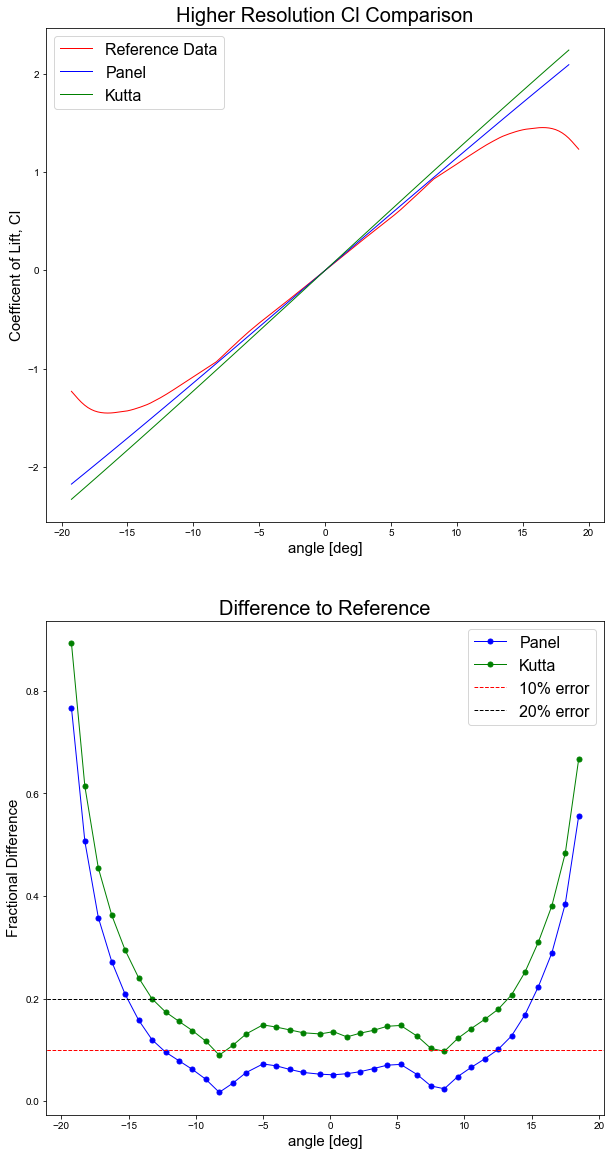

In [170]:
# setup
fig, axs = plt.subplots(2, 1, figsize=[10, 20])

# plot both values
axs[0].plot(data['Alpha'], data["Cl"], 'r-', label='Reference Data')
axs[0].plot(deg_angs, coefficents[0, :], 'b-', label=names[0])
axs[0].plot(deg_angs, coefficents[1, :], 'g-', label=names[1])
axs[0].legend()
axs[0].set(title="Higher Resolution Cl Comparison", xlabel="angle [deg]", ylabel="Coefficent of Lift, Cl")

# plot the difference
diff = lambda x:abs((x - data_trunc['Cl'])/data_trunc['Cl'])
axs[1].plot(deg_angs, diff(coefficents[0, :]), 'b-o', label=names[0])
axs[1].plot(deg_angs, diff(coefficents[1, :]), 'g-o', label=names[1])
axs[1].axhline(0.1, -20, 20, linestyle='--', c='r', label="10% error")
axs[1].axhline(0.2, -20, 20, linestyle='--', c='k', label="20% error")
axs[1].legend()
axs[1].set(title="Difference to Reference", xlabel="angle [deg]", ylabel="Fractional Difference")

We can see that the panel method has significant increase in agreement to the reference data, being always within $\pm10\%$ up to around $\pm12^o$ . The Kutta method on the other hand appears to have no significant improvement or even worsened from increasing the mesh resolution. This is relatively surprising as one would expect at least some improvement. A possible explanation is that only the mesh points directly next to the grid are used in the calculation of lift from the solution phi (which would be logical). Hence the increase of mesh resolution does affect significantly affect the points immediately next to the airfoil, as the vertices of the airfoil are fixed there.

## 5) Shape Factor and Its Derivative

Implementation of the derivative of the shape_factor function described in notebook two. You should include the test results for the function and any components it uses. Question 1. to 4. of notebook two.

The shape_factor function depends on the length, area, grad_length and grad_area functions, hence these need to be written and tested first. All but grad_area are given to us in the notebooks ("notebook_functions.py"), grad_area is written below.

In [75]:
def grad_area(x):
    """Compute the gradient of area(x)."""
    n = len(x)-1
    dadx = np.zeros((n+1, 2))
    for i in range(n):
        dadx[i,   0] +=  (x[i,1] + x[i+1, 1]) / 2
        dadx[i+1, 0] += -(x[i,1] + x[i+1, 1]) / 2
        dadx[i,   1] +=  (x[i,0] - x[i+1, 0]) / 2
        dadx[i+1, 1] +=  (x[i,0] - x[i+1, 0]) / 2
    return dadx

Now we need to test all these functions are working as expected. First we test the  length and area functions by comparing them to their analytical expectations for regular polygons

\begin{align*}
  p &= 2 n R \sin(\frac{\pi}{n}) \\
  A &= \tfrac 12 nR^2\sin(\frac{2\pi}n)
\end{align*}

Here I use the np.isclose function as the different methods of calculating length and area might have some minute rounding differences.

In [184]:
# tests for the regular polygon, area and length funcitions above

length_analytic = lambda R,n : 2*n*R*np.sin(np.pi/n)
area_analytic = lambda R,n : n*R*R*np.sin(2*np.pi/n)/2

radiuses = np.arange(1, 5)
edges = np.arange(3, 50)

print('testing \n R =', radiuses, '\n n =', edges, '\n')

for R in radiuses:
    for n in edges:
        poly = regular_polygon(R, n)
        assert np.isclose(length(poly), length_analytic(R, n)), 'legnth calc for %i, %i unequal' % (R, n)
        assert np.isclose(area(poly), area_analytic(R, n)), 'area calc for %i, %i unequal' % (R, n)

print('All tests passed')

testing 
 R = [1 2 3 4] 
 n = [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] 

All tests passed


Looks good, however this is not a complete test of the area and length functions as we expect them to work for non-regular polygons too (symmetry may cancel out some bug). Hence the following test of increasingly elongated rectangles is used to ensure non-regular shapes are also correct.

In [185]:

def rectangle(size, factor):
    "rectangle with one side length size and the other size*factor"
    x, y = size, size*factor
    cords = ([0, 0], [x, 0], [x, y], [0, y], [0, 0])
    return np.array(cords).reshape(-1,2)

length_analytic = lambda size,fac : 2*size*(1+fac)
area_analytic = lambda size,fac : size*size*fac

square_sizes = np.arange(1, 10, .5)
elongations = np.arange(10, 20, .5)

print('testing \n size =', square_sizes, '\n elongations =', elongations, '\n')

for s in square_sizes:
    for e in elongations:
        poly = rectangle(s, e)
        assert np.isclose(length(poly), length_analytic(s, e)), 'legnth calc for %i, %i unequal' % (s, e)
        assert np.isclose(area(poly), area_analytic(s, e)), 'area calc for %i, %i unequal' % (s, e)

print('All tests passed')

testing 
 size = [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.  9.5] 
 elongations = [10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5] 

All tests passed


From these we can be fairly confident that the area and length are correct. Now we need to test the grad_length and grad_area functions, for which we use the taylor_test given to us ("notebook_functions.py"). We expect the "convergence value" to be $\geq 2$ after some number of iterations, though in these case we fins it is almost exactly 2.

Length Taylor Test Ratio
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.85581655 1.94904724 1.98279472 1.99374229 1.99747478 1.99888897
 1.99948236 1.99975064 1.99987768 1.99993943 1.99996986 1.99998495
 1.99999247 1.99999594 1.99999596 2.00000496 1.99995339 1.99994157
 1.99974404]

Area Taylor Test Ratio
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.00000001 2.00000001
 1.99999987 1.99999959 2.00000401 1.99999475 2.00003778 1.99999831
 2.00046023]


[Text(0.5,1,'Area Taylor Test')]

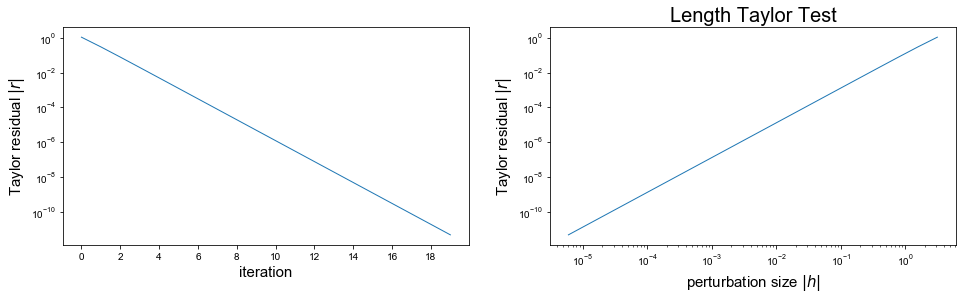

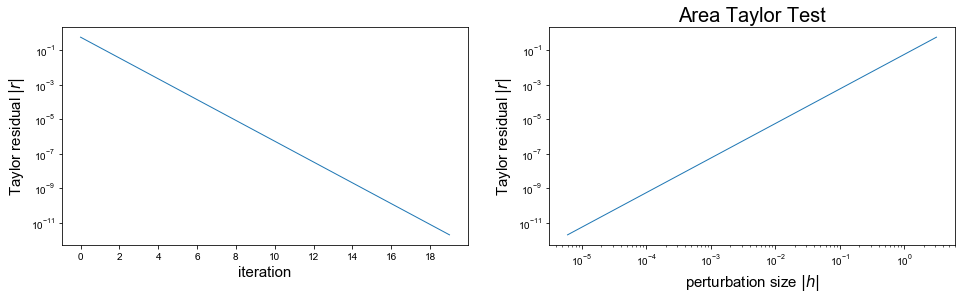

In [189]:
# setup am arbitary regular polygon
R = 1.5
n = 10
x = regular_polygon(R, n)

# use a random initial guess step
np.random.seed(0)
h0 = np.random.random((n+1, 2))

print("Length Taylor Test Ratio")
taylor_test(length, grad_length, x, h0)
plt.gca().set(title="Length Taylor Test")

print("\nArea Taylor Test Ratio")
taylor_test(area, grad_area, x, h0)
plt.gca().set(title="Area Taylor Test")

Both Taylor tests give very close to the expected ratio (order of convergence). Although values not perfect there are roundoff errors with floating point arithmetic which likely play a factor here owing to the very small differences that hop above and below 2. such errors are especially likely for numbers spanning large or small values as we have here since only the first 6 significant figures are guaranteed to be preserved when stored between calculations. 


One thing that is worth noting is that the residual for the area is quadratic in x, therefore its change under a perturbation $h$ is proportional to $h^2$. Perimeter (length function) on the other hand is linear therefore the change is proportional to $h$. Hence the zeroth iteration error for area is smaller than that of length. As we as decreasing the perturbation by half each time (i.e. quadratically), this difference in error is essentially the same as area having an extra iteration over length.


As we are confident all the need functions are working as expected we can write the shape function and the grad_shape function.

In [73]:
def shape_factor(x):
    """Computes the ratio l/sqrt{A}"""
    return length(x)/np.sqrt(area(x))

def grad_shape_factor(x):
    A = area(x)
    fac1 = grad_length(x) / np.sqrt(A)
    fac2 = length(x) * grad_area(x) * (-1/2) * A**(-3/2)
    return fac1 + fac2

We can test these with the Taylor test just as we did before with the same shape (x) and initial offset (h0).

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.95904809 1.97916309 1.99227799 1.99706986 1.99878505 1.99945598
 1.99974388 1.99987591 1.99993895 1.99996972 1.99998493 1.99999246
 1.9999962  1.99999778 1.99999887 2.00000465 1.99997956 1.99993365
 2.0000032 ]


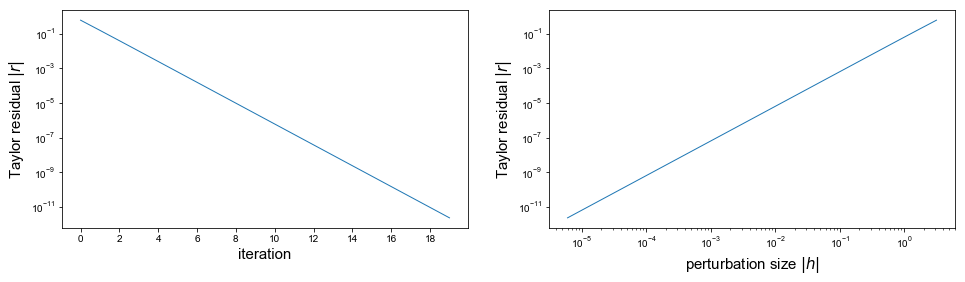

In [191]:
taylor_test(shape_factor, grad_shape_factor, x, h0)

Again we have a good value of very close to 2. Hence we can be pretty sure that both shape_factor and grad_shape_factor are working correctly too.

## 6) Experiments with Optimisation Based on Shape Factor
Simply copy and describe your answers to questions 5. to 8. of notebook two. NOTE: In question 6.
you were asked to include the newton-cg method, the intention was to show that this method, a pure
Newton method, is not very efficient as it needs to approximate the Hessian by evaluating the
Jacobian many times. However it turns out that the method for approximating the Hessian is not very
reliable either, often causing the optimisation to not converge at all. If this is what you find, simply
state these observations in your report.

First we are asked about the optimal shape for a smallest shape factor. It naturally makes sense that this is a circle (in fact this is the reason why bubbles are spherical), however calculus proofs for this seem convoluted, so instead we will use computational minimisation method to show this. Analytically we expect a circle to have shape factor:

$$
  Q = \frac{l}{\sqrt{A}} = \frac{2 \pi r}{\sqrt{\pi r^2}} = 2 \sqrt{\pi}
$$

We will use the ShapeOptimisationProblem class (from notebook_functions.py) to optimise our shapes, which is a wrapper around the scipy.optmise.minimise function that handles array so our previous functions are compatible. However the number of vertices present will be a limit on how close to a circle we can get (as it would require infinite vertices to be a circle). To reduce this affect I will load the given shape with the highest number of vertices, which is uk2.dat. Note we can't use the regular polygon shape generator to generate a shape of arbitrary points here because we will converge to as a regular polygon anyway (as this is as close to a circle one can get with a fixed number of vertices).

In [76]:
# load the shape
x0 = np.loadtxt('data/uk2.dat')

# setup the solving class
so = ShapeOptimisationProblem(x0, shape_factor, grad_shape_factor, 
                              store_function_evaluations=True, store_gradient_evaluations=True)

# solve for up to 500 iterations
result = so.minimize(method='bfgs', options={'maxiter': 500})

In [77]:
# print the solver outcome
print("Did the solver succeed:", result['success'])
print("Solver message:", result['message'])
print("Number of iterations:", result['nit'])
print("Number of function evaluations:", result['nfev'])
print("Number of Jacobian evaluations:", result['njev'])
print("Final function value:", result['fun'])
print("number of stored evaluations:", len(so.x_i))

Did the solver succeed: False
Solver message: Maximum number of iterations has been exceeded.
Number of iterations: 500
Number of function evaluations: 508
Number of Jacobian evaluations: 508
Final function value: 3.5466339658188417
number of stored evaluations: 1016


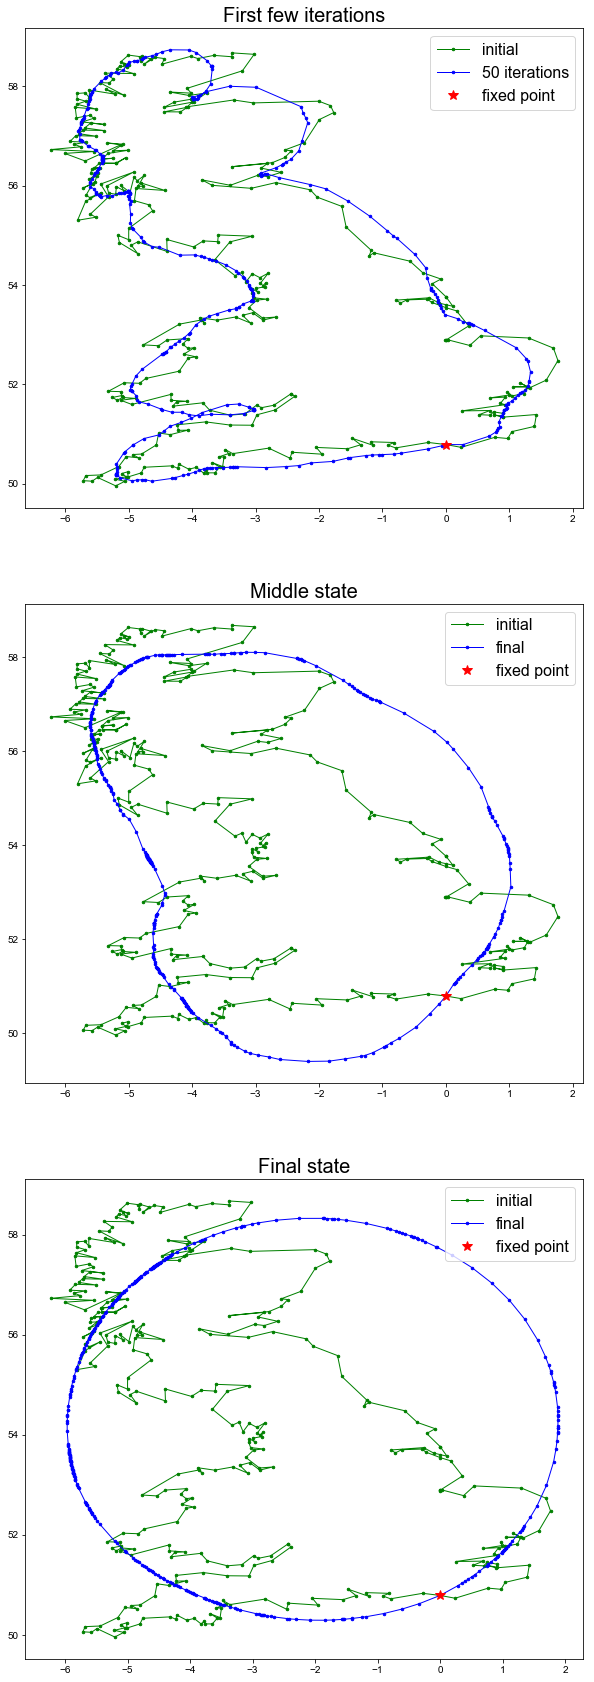

In [78]:
# plot the optimised shapes
fig, axs = plt.subplots(3,1, figsize=[10, 30])

# initial and after a few iteraions
axs[0].plot(so.x_i[0][:,0], so.x_i[0][:,1], 'g.-', label="initial")
axs[0].plot(so.x_i[50][:,0], so.x_i[50][:,1], 'b.-', label="50 iterations")
axs[0].set(title="First few iterations")

# initial and middle
axs[1].plot(so.x_i[0][:,0], so.x_i[0][:,1], 'g.-', label="initial")
mid = int(len(so.x_i)/2)
axs[1].plot(so.x_i[mid][:,0], so.x_i[mid][:,1], 'b.-', label="final")
axs[1].set(title="Middle state")

# initial and final
axs[2].plot(so.x_i[0][:,0], so.x_i[0][:,1], 'g.-', label="initial")
axs[2].plot(so.x_i[-1][:,0], so.x_i[-1][:,1], 'b.-', label="final")
axs[2].set(title="Final state")

for ax in axs:
    ax.plot(so.x_i[0][0,0], so.x_i[0][0,1], 'r*', ms=10, label="fixed point")
    ax.legend()
plt.show()

Looks pretty circular, however the solver claims it has not finished optimising. This is because the optimal shape has equally space points on the circles perimeter which the solver is struggling to do. This is seen by comparing the middle and final states and is likely because each point gets in the way of the point besides it so areas of high density have to diffuse out slowly. To fully appreciate that this is the minimum Q lets look at how the difference between the shape factor and the expected value develops.

Text(0.5,1,'Shape Factor Error')

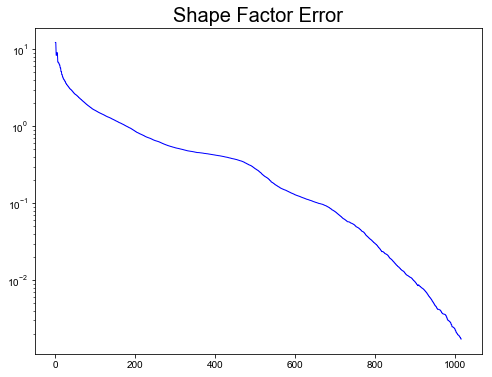

In [79]:
sf_circle = 2*np.sqrt(np.pi)
diff = [shape_factor(s) - sf_circle for s in so.x_i]
N = len(so.x_i)

plt.figure(figsize=[8,6])
plt.semilogy(range(N), diff, 'b-')
plt.title("Shape Factor Error")

Note we have more values than our iteration cap due to multiple Jacobian evaluations at each step is more than one. This is definitely converging and as I did not take the abs of the difference and we have no negative values (since semi-log y is happy), means we are converging from above as we expect from a minimum.

Next we are asked to compare bfgs with the newton-cg method. To ensure that newton-cg will actually work for this case lets check it on a low tolerance.

In [80]:
# solve for up to 500 iterations
result = so.minimize(method='newton-cg', options={'maxiter':10}, tol=1e-1)

# print the solver outcome
print("Did the solver succeed:", result['success'])
print("Solver message:", result['message'])
print("Number of iterations:", result['nit'])
print("Number of function evaluations:", result['nfev'])
print("Number of Jacobian evaluations:", result['njev'])
print("Final function value:", result['fun'])

Did the solver succeed: True
Solver message: Optimization terminated successfully.
Number of iterations: 1
Number of function evaluations: 10
Number of Jacobian evaluations: 21606
Final function value: 14.22973961425458


You can see that for this simpler problem with a low number of max iterations the minimisation routine claims to be within 0.1 of the solution after one iteration. And just looking at the result we can see that this is not the case ($14.229$ much larger than $2\sqrt{\pi}$). This is because (as mentioned in the question description) the approximation newton-cg makes to the Hessian matrix (would be the Jacobian for an inversion problem) is too unstable for this problem. Hence we can't compare this to the bfgs method, and without any method to compare with there is no point in timing the bfgs method (the results would have no meaning).

Next we asked to look at the affect of scaling the shape factor function on the number of runtime of bfgs.  As we are only using one method the runtime per-iteration should be constant, so we can just compare the iterations instead of runtimes, which means we will need to handle averaging the iterations ourselves. 

In [150]:
# select scale factors and tolerences
tols = resolutions # seem a reasonable choice
scale_facs = [1, 0.5, 0.1, 0.01]

# set the functions
sf_grad_funcs = [lambda x:1*grad_shape_factor(x), lambda x:0.5*grad_shape_factor(x),
                 lambda x:.1*grad_shape_factor(x), lambda x:0.01*grad_shape_factor(x)]
sf_funcs = [lambda x:1*shape_factor(x), lambda x:0.5*shape_factor(x),
            lambda x:.1*shape_factor(x), lambda x:0.01*shape_factor(x)]

# setup the ShapeOptimisationProblem instances
so_list = []
for f, grad in zip(sf_funcs, sf_grad_funcs):
    so_list.append( ShapeOptimisationProblem(x0, f, grad, False, False) )

# setup
iterations = np.zeros((len(scale_facs), len(tols)))

# for each tolerence
for i, tol in enumerate(tols):
    print ("iteration: ", i)
    for j, obj in enumerate(so_list):
        tmp = []
        # for each repeat
        for r in range(5):
            result = obj.minimize(method='bfgs', options={'maxiter':500}, tol=tol)
            tmp.append(result['nit'])
        iterations[j, i] = np.mean(tmp)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7


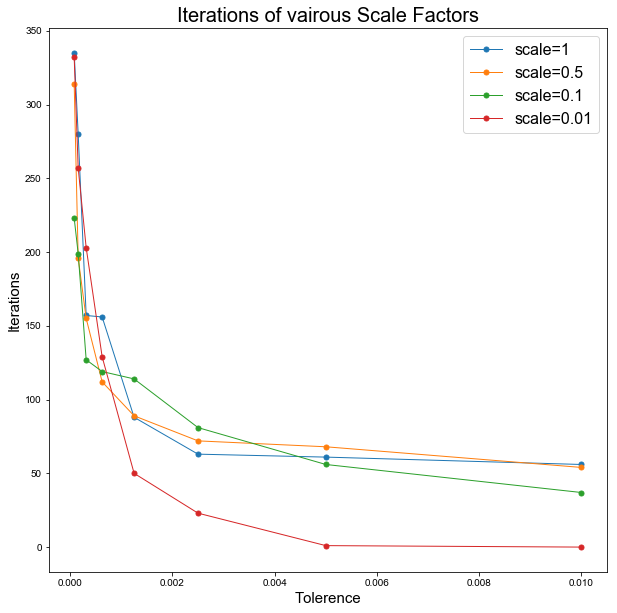

In [162]:
# plot the results
fig, ax = plt.subplots(figsize=[10, 10])
for i in range(len(scale_facs)):
    ax.plot(tols, iterations[i, :], '-o', label="scale=" + str(scale_facs[i]))
    
ax.set(xlabel='Tolerence', ylabel='Iterations', title='Iterations of vairous Scale Factors')
ax.legend()

We can see a the number of iterations required for relatively high tolerances is better the lower the scaling factor, however this trend is not clean as for the higher resolutions each method begins to overlap. This suggest that the "trick" to improve the iterations only saves a fixed number of iterations (say the first 10), and as such for longer simulations this benefit becomes unnoticeable with the variations of iterations.

Finally we are given two functions for shape factor and its gradient with a set aspect ratio, hence the optimal shape it should converge to is an ellipse. These are copied in below rather than in notebook_functions.py as they depend on the globally defined variable aspect ratio. 

We need to test that these two functions are correct with the Taylor test as we did previously with length, area and normal shape factor.

In [82]:
aspect_ratio = 10.0

def shape_factor_ar(x):
    x[:,1] *= aspect_ratio  # scale y-coordinates: ellipse -> circle
    Q = shape_factor(x)
    x[:,1] /= aspect_ratio   # change back y-coords
    return Q

def grad_shape_factor_ar(x):
    x[:,1] *= aspect_ratio  # scale y coordinates: ellipse -> circle
    dQdx = grad_shape_factor(x)
    x[:,1] /= aspect_ratio  # change back y-coords
    # also rescale the y-derivatives:
    dQdx[:,1] *= aspect_ratio
    return dQdx

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.47653546 1.50401181 1.66426172 1.84656591 1.95106589 1.98725693
 1.99702072 1.99939008 1.99991683 2.00001396 2.00002086 2.0000139
 2.00000778 2.00000397 2.00000131 1.99999552 1.99998488 1.99993521
 1.99992965]


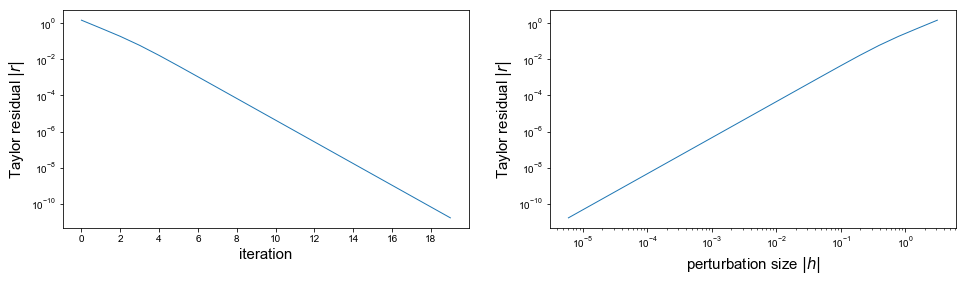

In [84]:
# setup a regular polygon
R = 1.5
n = 10
x = regular_polygon(R, n)

# use a random initial guess step
np.random.seed(0)
h0 = np.random.random((n+1, 2))

# run the taylor test
taylor_test(shape_factor_ar, grad_shape_factor_ar, x, h0)

We have a value of almost exactly 2 again so we can be confident that these functions are correct. To ensure that these create the ellipse as expected lets optimise the airfoil we previously loaded and see what we get.

In [85]:
# solve for the airfoil
so = ShapeOptimisationProblem(airfoil, shape_factor_ar, grad_shape_factor_ar)
result = so.minimize(method='bfgs', options={'maxiter': 1000})

# print the solver outcome
print("Did the solver succeed:", result['success'])
print("Solver message:", result['message'])
print("Number of iterations:", result['nit'])
print("Number of function evaluations:", result['nfev'])
print("Number of Jacobian evaluations:", result['njev'])
print("Final function value:", result['fun'])

Did the solver succeed: True
Solver message: Optimization terminated successfully.
Number of iterations: 138
Number of function evaluations: 156
Number of Jacobian evaluations: 156
Final function value: 3.5485592980797143


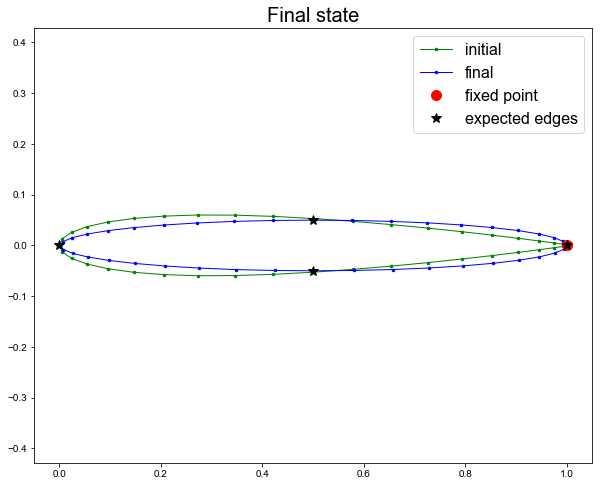

In [88]:
# plot the optimised shapes
fig, ax = plt.subplots(1,1, figsize=[10, 8])

# initial and final
ax.plot(so.x_i[0][:,0], so.x_i[0][:,1], 'g.-', label="initial")
ax.plot(so.x_i[-1][:,0], so.x_i[-1][:,1], 'b.-', label="final")
ax.plot(so.x_i[0][0,0], so.x_i[0][0,1], 'ro', ms=10, label="fixed point")
ax.plot([0, 0.5, 0.5, 1], [0, 0.05, -0.05, 0], 'k*', ms=10, label="expected edges")
ax.set(title="Final state")
ax.legend()
plt.axis('equal')
plt.show()

The final result is indeed an ellipse. Plotting stars at the edges expected (unchanged from a at the ends horizontal ends and $radius\times(aspect \; ratio)^{-1}$ on the vertical end) shows that we have the exact ellipse we expected.

## 8) Implementation of the Adjoint Method
Provide an implementation of the adjoint method to compute the derivative of the reduced
optimisation problem as formulated in notebook four, question 1. Include the testing you have done to
verify that the derivative is correct.

To begin with we need to create the function $\hat f(\vec x)$, which is the formulated reduced optimisation problem. This has a combination of the lift coefficient previously found and a cost from the shape factor to prevent non-physical results. 

To make this easier we have been provided with the AirfoilFunctional class (found in "notebook_functions.py") which gathers together most of the functions needed to implement this, including $f(\vsig, \vec x)$. We know how to find $\vsig$ from before using either PotentialFlowPanelMethod or KuttaPotentialFlowFE and there found optimal solvers. Then we feed that  into $f(\vsig, \vec x)$ to have a form of $\hat f(\vec x)$.

Here we use the PotentialFlowPanelMethod as it was better in the previous comparison to real data and is suggested by the task. Instead of using the previously found optimal solver GMRES we are advised to use a direct solver instead, hence we use sp.solve instead (not spl.spsolve as the matrix is dense here). 

Next we need to find its derivative in order to perform a minimisation, which is found from the adjoint method in the following equations:
$$
  \frac{d\hat f(\vec x)}{d\vec x} = \frac{\partial f(\vsig, \vec x)}{\partial \vec x} - \vlam\cdot \frac{\partial g(\vsig, \vec x)}{\partial \vec x}
$$
where we find lambda from
$$
    \mat A^T \vlam = \left(\frac{\partial f(\vsig, \vec x)}{\partial \vsig}\right)^T
$$
$\frac{f(\vsig, \vec x)}{\partial \vsig}$,  $\frac{\partial f(\vsig, \vec x)}{\partial \vec x}$, $\frac{\partial g(\vsig, \vec x)}{\partial \vec x}$ are all functions already made in AirfoilFunctional, hence all that is needed is to find $\vsig$ and $\vlam$. The latter needs to be found through solving a matrix equation, which again will be done with the direct solver sp.solve.

Now we are ready to create the functions for $\frac{d\hat f(\vec x)}{d\vec x}$ and $\hat f(\vec x)$, which we will wrap in a class to keep everything together.

In [24]:
class ReducedAirfoilFunctional:
    def __init__(self, af=AirfoilFunctional(), u_inf=1., alpha=0.):
        """
        Store the AirfoilFunctional class and parameters given.
        Note that aspect_ratio (20.0), Q_max (3.8), Q_scale (0.01), Q_eps (0.0001) 
        parameters for the reduced optimisation function are set in the 
        AirfoilFunctional class with default values given in the brackets.
        """
        self.af = af
        self.u_inf = u_inf
        self.alpha = alpha
        
        
    def find_sigma(self, x):
        pfpm = PotentialFlowPanelMethod(x, self.u_inf, self.alpha)
        self.A, self.b = pfpm.assemble()
        self.sigma = sl.solve(self.A, self.b)
        
        
    def fhat(self, x):
        self.find_sigma(x)
        return self.af.f(self.sigma, x)
    
    
    def grad_fhat(self, x):
        
        # find sigma
        self.find_sigma(x)
        
        # find the partial differentials
        dfds = self.af.grad_sigma_f(self.sigma, x)
        dfdx = self.af.grad_x_f(self.sigma, x)
        dgdx = panel_method_x_derivative(self.sigma, x, self.u_inf, self.alpha)
        
        # find lambda
        lam = sl.solve(self.A.T, dfds.T)
        
        # find the derivative
        lambda_dot_dgdx = np.tensordot(lam, dgdx, ((0,), (0,)))
        return dfdx - lambda_dot_dgdx


We now need to test that both fhat and grad_fhat have been written correctly with a Taylor test.

C_L, Q, penalty, f(sigma, x) 93.48220798629451 77.88888237502647 7408.990340906368 7315.508132920074
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) -0.9591933882646617 43.73105799821671 3993.2079032253914 3994.167096613656
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) -19.422208986560435 26.116009797929873 2231.7030831967068 2251.125292183267
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) -102.81169204958589 15.660321109331958 1186.1342143369156 1288.9459063865015
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) 0.20972394942534994 9.548921485344879 574.9942519382076 574.7845279887823
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254

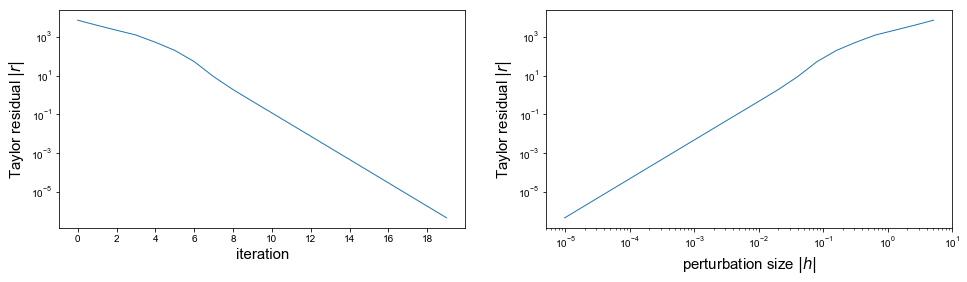

In [199]:
# create a defualt parameter choice reduced optimisation problem
rd = ReducedAirfoilFunctional()

# use a random initial guess step
np.random.seed(0)
h0 = np.random.random(airfoil.shape)

taylor_test(rd.fhat, rd.grad_fhat, airfoil, h0)

This looks good, after a number of iteration the value is almost exactly 2 as have seen before. This is a good sign that these functions have been written correctly, however some very odd behavior is seen if the Taylor test iterates to smaller steps. 

C_L, Q, penalty, f(sigma, x) 93.48220798629451 77.88888237502647 7408.990340906368 7315.508132920074
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) -0.9591933882646617 43.73105799821671 3993.2079032253914 3994.167096613656
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) -19.422208986560435 26.116009797929873 2231.7030831967068 2251.125292183267
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) -102.81169204958589 15.660321109331958 1186.1342143369156 1288.9459063865015
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) 0.20972394942534994 9.548921485344879 574.9942519382076 574.7845279887823
C_L, Q, penalty, f(sigma, x) -9.554990641093824e-16 4.254

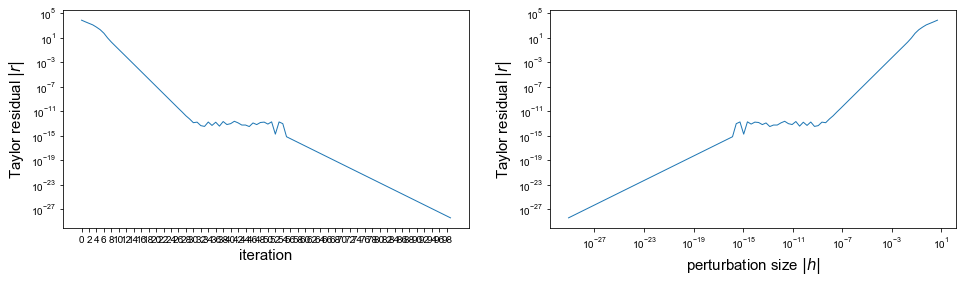

In [200]:
taylor_test(rd.fhat, rd.grad_fhat, airfoil, h0, max_iter=100)

Two new features become apparent, firstly a plateau followed by a area with a gradient of 1. The gradient of 1 is indicative of the solution not improving further (as we would expect this convergence order if we completely ignored the first derivative in the Taylor series). Something to note here is that we are requesting an unreasonable degree of accuracy from a routine which passes through multiple solvers. What it does demonstrate however is that caution needs to taken with the problem when it comes to increasing resolution passed into the routines.

## 9) Implementation of the Airfoil Shape Optimisation
Show the results of the optimisation in question 2. of notebook four. Provide clear user documentation
how a user might use the new optimisation functionality. Your code should be structured such that it is
easy to use without too many inbetween steps for a novice user, but is still flexible to adapt for the
expert user.

For the purposes of demonstration I will create all the required objects and load all the required data here, such that this section of the notebook is stand alone.

We have introduced an additional condition on the optimisation problem that the vertices may only move vertically, to prevent hook like structures from forming. This is kept in the VerticalShapeOptimisation (notebook_functions.py) which in all other aspects is the same as ShapeOptimisationProblem.

At this point we are essential calling everything we have previously made to optimise the airfoil. We are minimising the original airfoil with respect the function $\hat f$ and its gradient.


In [ ]:
# if copying this code these are the dependencies
# be sure to also include the ReducedAirfoilFunctional class above aswell
# import numpy as np
# import mtplotlib.pyplot as plt
# from potential_flow import *
# from panel_method_derivatives import panel_method_x_derivative
# from notebook_functions import AirfoilFunctional, VerticalShapeOptimisation

In [32]:
# load the initial shape we are going to optimise
airfoil = np.loadtxt("data/airfoil.dat")

# create the AirfoilFunctional instance with the parameters we want to solve with
af = AirfoilFunctional(verbose=True, aspect_ratio=20.0, Q_max=3.8, Q_scale=0.01, Q_eps=0.0001)
# this holds many of the maths functions used by the following classes

# create the ReducedAirfoilFunctional instance with the remaining parameters we want
rd = ReducedAirfoilFunctional(af=af, u_inf=1.0, alpha=0.)
# this has the function and derivative we are optimising for

# create the VerticalShapeOptimisation instance with the initial shape, function
# and gradient we are optimising for
vso = VerticalShapeOptimisation(airfoil, rd.fhat, rd.grad_fhat)
# this is a wrapper around scipy.optimize.minimise function

# finally call the minimisation routine with the method and tolerance wanted
result = vso.minimize(method="BFGS", tol=0.01, options={'maxiter': 500})

C_L, Q, penalty, f(sigma, x) -6.434280870417247e-16 4.254208081494124 45.52291155313214 45.52291155313214
C_L, Q, penalty, f(sigma, x) -1.2471840539467296 114.66419565923852 11086.521669327572 11087.76885338152
C_L, Q, penalty, f(sigma, x) 0.2185920525250552 11.064730291088956 726.5751325126155 726.3565404600904
C_L, Q, penalty, f(sigma, x) 0.01067017613568536 4.240222725886882 44.124375992408005 44.11370581627232
C_L, Q, penalty, f(sigma, x) 0.012517360826524439 4.215752242043623 41.67732760808204 41.66481024725552
C_L, Q, penalty, f(sigma, x) 0.016394045929319253 4.171961973902595 37.29830079397924 37.28190674804992
C_L, Q, penalty, f(sigma, x) 0.022545413861472307 4.122540772988829 32.35618070260271 32.333635288741235
C_L, Q, penalty, f(sigma, x) 0.027100630921478835 4.063765236055357 26.478627009255444 26.451526378333966
C_L, Q, penalty, f(sigma, x) 0.02946655048314278 4.075765778757407 27.678681279460445 27.649214728977302
C_L, Q, penalty, f(sigma, x) 0.028251238582817473 4.021366

We should check the solver's outcome.

In [33]:
# print the solver outcome
print("Did the solver succeed:", result['success'])
print("Solver message:", result['message'])
print("Number of iterations:", result['nit'])
print("Number of function evaluations:", result['nfev'])
print("Number of Jacobian evaluations:", result['njev'])
print("Final function value:", result['fun'])

Did the solver succeed: True
Solver message: Optimization terminated successfully.
Number of iterations: 141
Number of function evaluations: 176
Number of Jacobian evaluations: 176
Final function value: -1.4295071496591198


Lets look at the new airfoil.

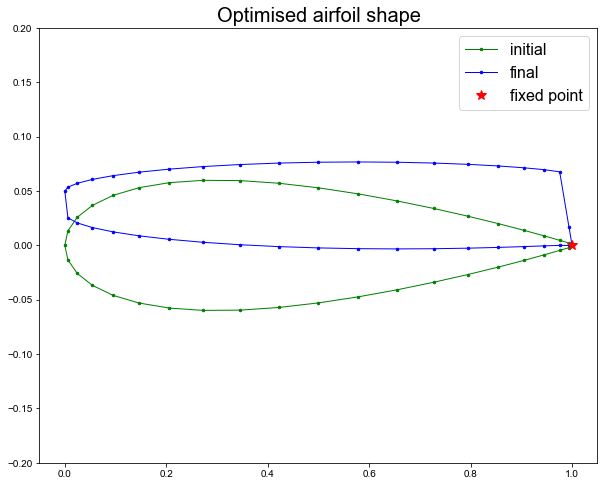

In [45]:
# plot the optimised airfoil
fig, ax = plt.subplots(figsize=[10, 8])

# initial and final
ax.plot(vso.x_i[0][:,0], vso.x_i[0][:,1], 'g.-', label="initial")
ax.plot(vso.x[:,0], vso.x[:,1], 'b.-', label="final")
ax.plot(vso.x_i[0][0,0], vso.x_i[0][0,1], 'r*', ms=10, label="fixed point")

# setup the axes
ax.set(title="Optimised airfoil shape", ylim=[-0.2, 0.2])
ax.legend()

plt.show()

This looks reasonable and wing like. In relation to the previous statement about the original airfoil seeming symmetric along $x=0$ meaning no lift at a zero angle of attack we can guess that the new wing will have some lift because it does not have this symmetry. Lets use the previous methods to evaluate what this lift coefficient would be.

In [54]:

# solve with Panel Method
pfpm = PotentialFlowPanelMethod(vso.x, u_inf=1., alpha=0.)
A, b = pfpm.assemble()
sigma = spl.gmres(A, b, tol=1e-5)[0]
print("PotentialFlowPanelMethod : ", pfpm.lift_coeffcient(sigma))

# solve with the Kutta method
kpf = KuttaPotentialFlowFE(vso.x, outer_boundary, 0.01, u_inf=1., alpha=0.)
A, b = kpf.assemble()
phi = spl.bicgstab(A, b, tol=1e-5)[0]
print("KuttaPotentialFlowFE : ", kpfs.lift_coeffcient(phi))


PotentialFlowPanelMethod :  1.479223135156509
KuttaPotentialFlowFE :  1.5717948555101173


Text(0.5,1,'New Wing Flow - kutta Method')

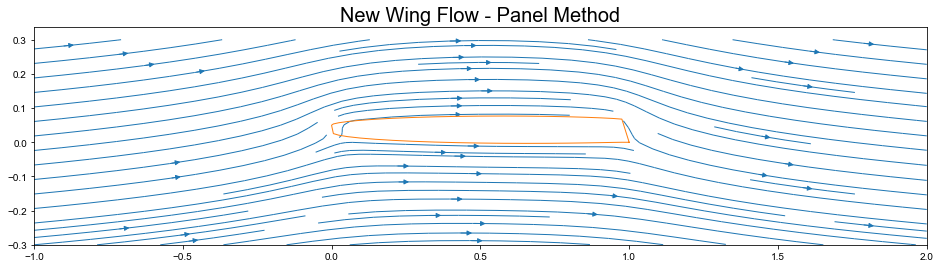

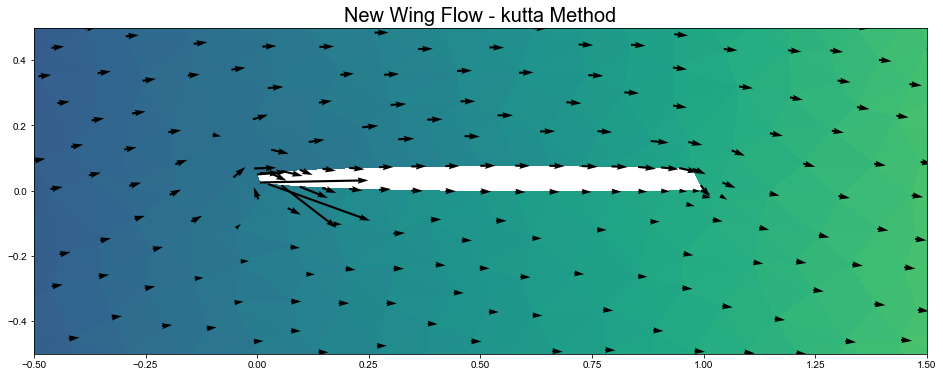

In [58]:
# plot the new wing flow pannel method
plt.figure(figsize=(16,4))
x, y = np.meshgrid(np.linspace(-1, 2, 40), np.linspace(-.3,.3, 40))
pfpm.plot_solution(sigma, x, y)
plt.title('New Wing Flow - Panel Method')

# plot the new wing flow kutta method
plt.figure(figsize=(16,6))
kpf.plot_solution(phi)
plt.axis([-0.5, 1.5, -0.5, 0.5])
plt.title('New Wing Flow - kutta Method')

These numbers are in agreement but slightly different. There are multiple possible reasons for this as explained in notebook 4, in summary:

- `KuttaPotentialFlowFE` outer boundaries needs to be unperturbed upstream flow
- `KuttaPotentialFlowFE` depend on an arbitrary mesh resolution
- large straight edges reduced the accuracy of `PotentialFlowPanelMethod`

The lift has improved from the previously where is was it was zero (as seen from the reference data and results in question 4), meaning in this case we have somewhat a viable wing. 

Looking at the flow simulations though at first they seem a bit poor they are actually quite good. Panel's slight overlap at the front is present for the default airfoil, just much smaller, is probably some kind of interpolation error the stream lines. As for th kutta method the large arrows are simply representative of high flow velocity at the tip of the wing, which one would expect from the blunt front.

The shape factor cost and verticle restrictions have prevented serious non-physical properties, however comparing this to a planes wing there are some noticeable differences.

<img src="data/airfoil_pic.jpg" alt="picture of a real airfoil">

The blunt edge in the direction of airflow is normally more rounded as this would cause significant drag due to ram pressure. This is understandable as we have not included drag in this model. If I were to go about including drag I would try to quantify the momentum imparted onto the wing by the air, but in this model we have required no normal velocity on the wings surface, hence momentum can only be imparted by friction and not ramming. Incorporating both would likely require an entire overhaul of this simulation because of this.

The tapered end in the real wing is due to turbulent causing instabilities. Again something this model does not account for. Actual plane wings also have to include several other factors, such as being viable for a range of attack angles and maximum stresses that certain parts of the wing can cope with. 

One other issue the weight of the wing, which is mostly affected by the thickness (since length is fixed here). This is influenced by our choice of aspect ratio, which was completely arbitary. If we were to vary this to a higher or lower value we would expect a thinner and thicker wing respectively. Lets test this now.

In [62]:
# solve for lower ar
af = AirfoilFunctional(verbose=True, aspect_ratio=10.0, Q_max=3.8, Q_scale=0.01, Q_eps=0.0001)
rd = ReducedAirfoilFunctional(af=af, u_inf=1.0, alpha=0.)
vso_lar = VerticalShapeOptimisation(airfoil, rd.fhat, rd.grad_fhat)
result = vso_lar.minimize(method="BFGS", tol=0.01, options={'maxiter': 500})

C_L, Q, penalty, f(sigma, x) -6.434280870417247e-16 3.720201874593224 0.025282552659454546 0.025282552659455188
C_L, Q, penalty, f(sigma, x) 2.4844675176190396 29.84958166119822 2605.0602695235416 2602.5758020059225
C_L, Q, penalty, f(sigma, x) 0.08299366182043758 3.723738896149999 0.02573592249834495 -0.057257739322092625
C_L, Q, penalty, f(sigma, x) 0.2716735165802726 3.837182148612401 3.8203182649598717 3.548644748379599
C_L, Q, penalty, f(sigma, x) 0.11723757567773598 3.7346656109418443 0.027282367494968852 -0.08995520818276712
C_L, Q, penalty, f(sigma, x) 0.5240847429297398 3.881080406315856 8.210144035305373 7.686059292375632
C_L, Q, penalty, f(sigma, x) 0.12055561548598473 3.73621908591033 0.02752301285585873 -0.093032602630126
C_L, Q, penalty, f(sigma, x) 0.12377125024266386 3.7377622649861704 0.027767937909401547 -0.09600331233326231
C_L, Q, penalty, f(sigma, x) 0.288101840878101 3.8071699165843897 0.8190950621587542 0.5309932212806532
C_L, Q, penalty, f(sigma, x) 0.1690594415

In [63]:
# print the solver outcome
print("Did the solver succeed:", result['success'])
print("Solver message:", result['message'])
print("Number of iterations:", result['nit'])
print("Number of function evaluations:", result['nfev'])
print("Number of Jacobian evaluations:", result['njev'])
print("Final function value:", result['fun'])

Did the solver succeed: True
Solver message: Optimization terminated successfully.
Number of iterations: 169
Number of function evaluations: 204
Number of Jacobian evaluations: 204
Final function value: -2.4337808429296826


In [30]:
# solve for higher ar
af = AirfoilFunctional(verbose=True, aspect_ratio=30.0, Q_max=3.8, Q_scale=0.01, Q_eps=0.0001)
rd = ReducedAirfoilFunctional(af=af, u_inf=1.0, alpha=0.)
vso_har = VerticalShapeOptimisation(airfoil, rd.fhat, rd.grad_fhat)
result = vso_har.minimize(method="BFGS", tol=0.01, options={'maxiter': 500})

C_L, Q, penalty, f(sigma, x) -6.434280870417247e-16 4.904781836525115 110.58028705623124 110.58028705623124
C_L, Q, penalty, f(sigma, x) 2.477479918674994 143.99216278801802 14019.318382205522 14016.840902286847
C_L, Q, penalty, f(sigma, x) 0.0756532861323167 15.169509930793554 1137.0530964830753 1136.9774431969429
C_L, Q, penalty, f(sigma, x) 0.007233353698694611 5.153620657160289 135.46416911974868 135.45693576604998
C_L, Q, penalty, f(sigma, x) 0.0018455788901489624 4.829934981934456 103.09560159716538 103.09375601827523
C_L, Q, penalty, f(sigma, x) 0.005200167028104916 4.744629624817125 94.56506588543228 94.55986571840417
C_L, Q, penalty, f(sigma, x) 0.010098847196543623 4.751646708058386 95.26677420955839 95.25667536236185
C_L, Q, penalty, f(sigma, x) 0.0075371352102633965 4.700147897359964 90.11689313971623 90.10935600450597
C_L, Q, penalty, f(sigma, x) 0.010847275066762672 4.620288375874198 82.13094099113957 82.1200937160728
C_L, Q, penalty, f(sigma, x) 0.017280397756370802 4.58

In [31]:
# print the solver outcome
print("Did the solver succeed:", result['success'])
print("Solver message:", result['message'])
print("Number of iterations:", result['nit'])
print("Number of function evaluations:", result['nfev'])
print("Number of Jacobian evaluations:", result['njev'])
print("Final function value:", result['fun'])

Did the solver succeed: True
Solver message: Optimization terminated successfully.
Number of iterations: 177
Number of function evaluations: 229
Number of Jacobian evaluations: 229
Final function value: -1.030699286428894


Let look at the lift values and shapes of these airfoils

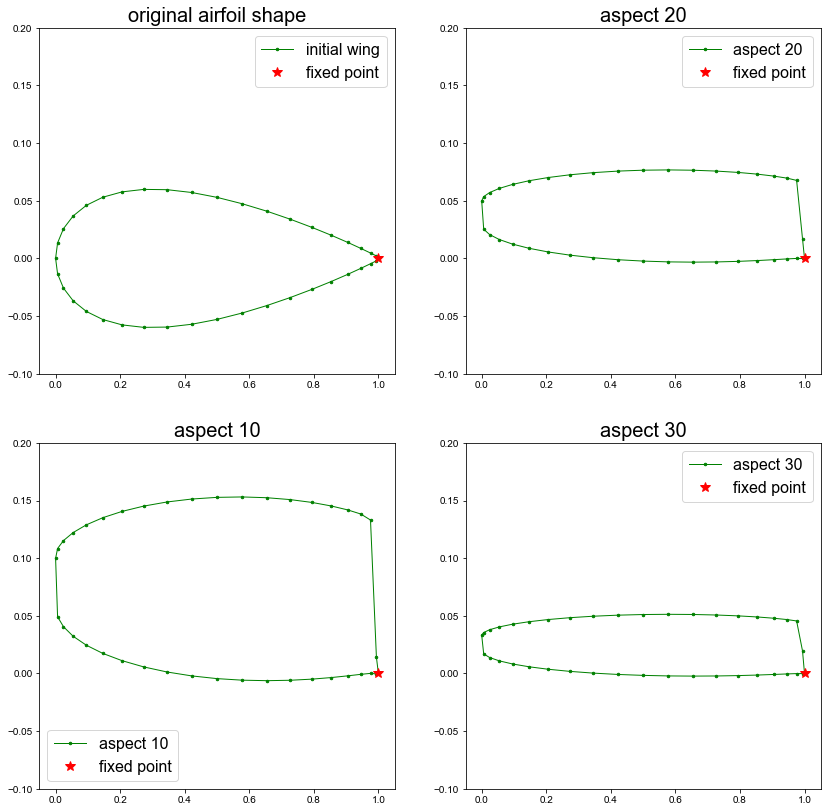

In [67]:
# plot the optimised airfoil
fig, axs = plt.subplots(2, 2, figsize=[14, 14])
axs = axs.flatten()

# initial
axs[0].plot(vso.x_i[0][:,0], vso.x_i[0][:,1], 'g.-', label="initial wing")
axs[0].set(title="original airfoil shape")

# low aspect ratio
axs[1].plot(vso_lar.x[:,0], vso_lar.x[:,1], 'g.-', label="aspect 10")
axs[1].set(title="aspect 10")

# original airfoil
axs[2].plot(vso.x[:,0], vso.x[:,1], 'g.-', label="aspect 20")
axs[2].set(title="aspect 20")

# high aspect ratio
axs[3].plot(vso_har.x[:,0], vso_har.x[:,1], 'g.-', label="aspect 30")
axs[3].set(title="aspect 30")

for ax in axs:
    ax.plot(vso.x_i[0][0,0], vso.x_i[0][0,1], 'r*', ms=10, label="fixed point")
    ax.set(ylim=[-0.1, 0.2])
    ax.legend()

plt.show()

In [71]:
# find the lift values

names = ["low", "mid", "high"]
for i, obj in enumerate([vso_lar, vso, vso_har]): 

    # solve with Panel Method
    pfpm = PotentialFlowPanelMethod(obj.x, u_inf=1., alpha=0.)
    A, b = pfpm.assemble()
    sigma = spl.gmres(A, b, tol=1e-5)[0]
    print("PotentialFlowPanelMethod for " + names[i] + " : ", pfpm.lift_coeffcient(sigma))

    # solve with the Kutta method
    kpf = KuttaPotentialFlowFE(obj.x, outer_boundary, 0.01, u_inf=1., alpha=0.)
    A, b = kpf.assemble()
    phi = spl.bicgstab(A, b, tol=1e-5)[0]
    print("KuttaPotentialFlowFE for " + names[i] + " ", kpfs.lift_coeffcient(phi), "\n")


PotentialFlowPanelMethod for low :  2.47774475644154
KuttaPotentialFlowFE for low  3.007213601132799 

PotentialFlowPanelMethod for mid :  1.479223135156509
KuttaPotentialFlowFE for mid  1.5717948555101173 

PotentialFlowPanelMethod for high :  1.079893300142683
KuttaPotentialFlowFE for high  1.04821343072341 



We see quite a clear trend of increasing the aspect ratio decreasing the wings width and therefore decreasing the wings lift value. However the thinner wings seem more realistic based due to less of a blunt front, but this is coincidental as our solver does not consider this. 

Playing with other parameters, particularly $Q_{max}$ will affect the priority of the solver between optimal shape factor and optimal lift, changing the outcome of wing shape. If I had more time I would test this prediction and see what parameters give the best wing shape.